In [ ]:
import os
from google.colab import drive
from google.colab import files
import random
import pandas as pd
import time
import numpy as np
import h5py
from torch.utils.data import Dataset
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.utils as vutils
import matplotlib.animation as animation
import matplotlib.pyplot as plt
from torch.nn.modules.activation import LeakyReLU
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [ ]:
!pip install torchinfo
from torchinfo import summary
!pip install spectrum
from spectrum import *

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 230 kB 5.0 MB/s 
     |████████████████████████████████| 47 kB 3.2 MB/s 
  Created wheel for spectrum: filename=spectrum-0.8.1-cp37-cp37m-linux_x86_64.whl size=235156 sha256=a1830fe9f783608fdbf3d31b72619027ba7a906e17e1766a3108474f9151796e
  Stored in directory: /root/.cache/pip/wheels/79/db/9c/92fa684ca088447807d08672e7609b48102c6161ac9c7e3c62
  Created wheel for easydev: filename=easydev-0.12.0-py3-none-any.whl size=64232 sha256=87915ca144d148493d7c6583cef1e1127980da268bb69dedada04ff5afe0f05d
  Stored in directory: /root/.cache/pip/wheels/82/ab/83/fdfc4017ea44a585b6754752cc5f63f2d0d63fcc1317e7174b
Successfully built spectrum easydev


In [ ]:
!mkdir data
!cp /content/gdrive/MyDrive/Colab\ Notebooks/PPG\ Classifier/data_PPG_Dalia_denoise_ppg_filtered_sync.h5 /content/data
#!cp /content/gdrive/MyDrive/Colab\ Notebooks/PPG\ Classifier/data_PPG_Dalia_denoise_ppg.h5 /content/data

In [ ]:
## 10-fold
indexbase=list(range(1,16))
indextest=random.sample(indexbase, 2)
indexkfold=indexbase.copy()
indexkfold.remove(indextest[0])
indexkfold.remove(indextest[1])
list_indexval=[]
for k in range(0,10):
    list_indexval.append([indexkfold[int((2*k)%13)],indexkfold[(2*k+1)%13]])

In [ ]:
def k_fold_sets(number_of_subject,test_number,val_number,folds):
  indexbase=list(range(1,number_of_subject+1))
  indextest=random.sample(indexbase, test_number)
  indexkfold=indexbase.copy()
  for index in indextest:
    indexkfold.remove(index)
  list_indexval=[]
  for k in range(0,folds):
      list_indexval.append([indexkfold[int((val_number*k+j)%13)] for j in range(0,val_number)])
  return indexkfold,list_indexval,indextest

In [ ]:
indexkfold,list_indexval,indextest=k_fold_sets(7,1,1,1)

In [ ]:
indexkfold,list_indexval,indextest

([1, 3, 4, 5, 6, 7], [[1]], [2])

In [ ]:
class ds_ppg(Dataset):
    def __init__(self, list_dic):
        self.samples = []
        for dic in list_dic:
            for i in range (0,dic["label"].shape[0]):
                label=dic["label"][i]
                x=dic["data"][i]
                hr_label=(dic["hr"][i])/250
                spectrum=dic["spectrum"][i]
                self.samples.append((x,label,hr_label,spectrum))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, id):
        return self.samples[id]

class ds_ppg_clean_t(Dataset):
    def __init__(self, net, dataloader):
        self.samples = []
        net.eval()
        for j, dataj in enumerate(dataloader, 0):  
            x=dataj[0].float().to("cuda")
            yhat=dataj[1].float().to("cuda")
            zhat=dataj[2].float().to("cuda")
            for k in range(1):
              xnoise=x+np.sqrt(0.002)*torch.randn(x.shape).float().to("cuda")
              y=net(xnoise)
              ynoise=y+np.sqrt(0.004)*torch.randn(y.shape).float().to("cuda")
              yconcat=torch.concat([ynoise,xnoise[:,1:,:]],dim=1)
              ypre_fft= yconcat.unfold(2,128,40).float().detach().cpu().numpy()
              for n0 in range(0,ypre_fft.shape[0]):
                item=np.array([])
                for n1 in range(0,ypre_fft.shape[1]):
                  spectr=np.array([])
                  for n2 in range(0,ypre_fft.shape[2]):
                    signal=ypre_fft[n0,n1,n2]
                    psd30_w=ar_psd(signal,30,64,5000,1)
                    psd30_2w=ar_psd(signal,30,64,5000,2)
                    psd100_w=ar_psd(signal,30,64,5000,1)
                    psd100_2w=ar_psd(signal,30,64,5000,2)
                    spectr=np.concatenate([spectr,psd30_w])
                  item=np.concatenate([item,spectr])
                self.samples.append((x[n0].detach().cpu().numpy(),yhat[i].detach().cpu().numpy(),ynoise[i].detach().cpu().numpy(),
                                    item,zhat[i].detach().cpu().numpy()))
              yfft=torch.abs(torch.fft.fft(ypre_fft,dim=3,n=5000,norm="ortho"))[:,:,:,:314]
              for i in range(yfft.shape[0]):
                self.samples.append((x[i].detach().cpu().numpy(),yhat[i].detach().cpu().numpy(),ynoise[i].detach().cpu().numpy(),
                                    yfft[i].detach().cpu().numpy(),zhat[i].detach().cpu().numpy()))


    def __len__(self):
        return len(self.samples)

    def __getitem__(self, id):
        return self.samples[id]

def ar_psd(signal,order,freq,NFFT,a):
    ar, P, k = aryule(signal, order, norm='biased')
    psd=arma2psd(ar,T=freq,NFFT=NFFT)[int(a*39):int(a*314):a]
    return psd


class ds_ppg_clean_v(Dataset):
    def __init__(self, net, dataloader):
        self.samples = []
        net.eval()
        for j, dataj in enumerate(dataloader, 0):  
            x=dataj[0].float().to("cuda")
            yhat=dataj[1].float().to("cuda")
            zhat=dataj[2].float().to("cuda")
            for k in range(1):
              y=net(x)
              yconcat=torch.concat([y,x[:,1:,:]],dim=1)
              ypre_fft= yconcat.unfold(2,124,20)
              yfft=torch.abs(torch.fft.fft(ypre_fft,dim=3,n=5000,norm="ortho"))[:,:,:,:314]
              for i in range(yfft.shape[0]):
                self.samples.append((x[i].detach().cpu().numpy(),yhat[i].detach().cpu().numpy(),y[i].detach().cpu().numpy(),
                                    yfft[i].detach().cpu().numpy(),zhat[i].detach().cpu().numpy()))


    def __len__(self):
        return len(self.samples)

    def __getitem__(self, id):
        return self.samples[id]

In [ ]:
def gen_list_dict_test(indextest):
    out=[]
    for i in indextest:
        data=h5f['data_S{}'.format(i)][:]
        label=h5f['label_S{}'.format(i)][:]
        dic={}
        dic["label"]=h5f['label_S{}'.format(i)][:]
        dic["data"]=h5f['data_S{}'.format(i)][:]
        dic["hr"]=h5f['hr_S{}'.format(i)][:]
        out.append(dic.copy())
    return out
def gen_list_dict_kfold(indexkfold,indexval):
    out_val=[]
    out_train=[]
    for i in indexkfold:
        dic={}
        dic["label"]=h5f['label_S{}'.format(i)][:]
        dic["data"]=h5f['data_S{}'.format(i)][:]
        dic["hr"]=h5f['hr_S{}'.format(i)][:]
        if i in indexval:
            out_val.append(dic.copy())
        else:
            out_train.append(dic.copy())
    return out_train,out_val

In [ ]:
"""
Finally the structure is  Dataset_kfold has 10 elements which are [Dataset training, Dataset val]
Dataset_test is the testing dataset.
Each Dataset has X samples and each sample is [data,label]
"""
os.chdir("/content")
#h5f = h5py.File('./data/data_PPG_Dalia_denoise_ppg.h5','r')
h5f = h5py.File('./data/data_PPG_Dalia_denoise_ppg_filtered_sync.h5','r')
Datasets_kfold=[]
for indexval in list_indexval:
    list_dict_train,list_dict_val=gen_list_dict_kfold(indexkfold,indexval)
    Datasets_kfold.append([ds_ppg(list_dict_train),ds_ppg(list_dict_val)])
list_dict_test=gen_list_dict_test(indextest)
Dataset_test=ds_ppg(list_dict_test)
h5f.close()

In [ ]:
def conv2d(h,k,s,p):
    return 1+(h+2*p-(k-1)-1)/s

In [ ]:
conv2d(320,15,1,7)

320.0

In [ ]:
conv2d(19,5,2,0)

8.0

## Models

In [ ]:
def init_weight(m):
    if isinstance(m,nn.Conv2d):
        nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)
    if isinstance(m,nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)
    if isinstance(m,nn.Conv1d):
        nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)
    if isinstance(m,nn.ConvTranspose1d):
        nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)
    if isinstance(m, nn.BatchNorm2d):
        m.weight.data.fill_(1)
        m.bias.data.zero_()



class Model(nn.Module):
    def __init__(self, ngpu):
        super(Model, self).__init__()
        self.ngpu = ngpu
        self.kernel=128
        self.nnStart = nn.Sequential(
            nn.Conv1d(
                in_channels=4,
                out_channels=self.kernel,
                kernel_size=15,
                stride=1,
                padding=7,
                bias=True
            ),#320xk
            nn.LeakyReLU(0.2),#41x1
            
        )
        self.list_hidden = nn.ModuleList([nn.Sequential(
            nn.Conv1d(
                in_channels=self.kernel,
                out_channels=self.kernel,
                kernel_size=15,
                stride=1,
                padding=7,
                bias=True
            ),#320xk
            nn.BatchNorm1d(self.kernel),
            nn.LeakyReLU(0.2),#41x1
            nn.Dropout(0.3),
        ) for i in range(0,15)])

        self.nnEnd = nn.Sequential(
            nn.Conv1d(
                in_channels=self.kernel,
                out_channels=1,
                kernel_size=15,
                stride=1,
                padding=7,
                bias=True
            ),#320xk
            nn.Tanh(),
        )

    def forward(self, input):
        input=self.nnStart(input)
        for k in range(0,15):
          input=self.list_hidden[k](input)
        output=self.nnEnd(input)
        return output


#input b_sizex4x10x314
class Model_Prediction(nn.Module):
    def __init__(self, ngpu):
        super(Model_Prediction, self).__init__()
        self.ngpu = ngpu
        self.kernel=32
        self.nnStart = nn.Sequential(
            nn.Conv2d(
                in_channels=4,
                out_channels=self.kernel,
                kernel_size=[3,16],
                stride=[1,1],
                padding=[1,4],
                bias=True
            ),#b_sizex4x10x307
            nn.MaxPool2d(
                kernel_size=[1,2],
                stride=[1,2],
            ),
            nn.BatchNorm2d(self.kernel),
            nn.LeakyReLU(0.2),#b_size x kernel x 10x153
            
        )
        self.list_conv = nn.ModuleList([nn.Sequential(
            nn.Conv2d(
                in_channels=(2**i)*self.kernel,
                out_channels=(2**(i+1))*self.kernel,
                kernel_size=[3,16],
                stride=[1,1],
                padding=[1,4],
                bias=True
            ),#b_size x (2**(i+1))*    2xk,4xk,8xk =256            x 10 x      146,66,26
            nn.MaxPool2d(
                kernel_size=[1,2],
                stride=[1,2],
            ),
            nn.BatchNorm2d((2**(i+1))*self.kernel),
            nn.LeakyReLU(0.2),#b_size x 2xk,4xk,8xk =256    x 10    x      73,33,13
            nn.Dropout(0.3)
        ) for i in range(0,3)])

        self.nnEnd = nn.Sequential(
            nn.Conv2d(
                in_channels=(2**3)*self.kernel,
                out_channels=(2**4)*self.kernel,
                kernel_size=[1,13],
                stride=[1,1],
                padding=[0,0],
                bias=True
            ),#b_size x (2**4)*k=512            x 10 x      1
            nn.MaxPool2d(
                kernel_size=[2,1],
                stride=[2,1],
            ),
            nn.BatchNorm2d((2**4)*self.kernel),
            nn.LeakyReLU(0.2),#b_size x 512    x 5    x      1

            nn.Conv2d(
                in_channels=(2**4)*self.kernel,
                out_channels=(2**3)*self.kernel,
                kernel_size=[5,1],
                stride=[1,1],
                padding=[0,0],
                bias=True
            ),#b_size x 256  x 1 x      1
            nn.BatchNorm2d((2**3)*self.kernel),
            nn.Flatten(),
            nn.Linear((2**3)*self.kernel,1),
            nn.Sigmoid(),#b_size x 1
        )

    def forward(self, input):
        input=self.nnStart(input)
        for k in range(0,3):
          input=self.list_conv[k](input)
        output=self.nnEnd(input)
        return output.view(-1)


In [ ]:
net= Model("cuda").to("cuda")
net.apply(init_weight)

Model(
  (nnStart): Sequential(
    (0): Conv1d(4, 128, kernel_size=(15,), stride=(1,), padding=(7,))
    (1): LeakyReLU(negative_slope=0.2)
  )
  (list_hidden): ModuleList(
    (0): Sequential(
      (0): Conv1d(128, 128, kernel_size=(15,), stride=(1,), padding=(7,))
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
      (3): Dropout(p=0.3, inplace=False)
    )
    (1): Sequential(
      (0): Conv1d(128, 128, kernel_size=(15,), stride=(1,), padding=(7,))
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
      (3): Dropout(p=0.3, inplace=False)
    )
    (2): Sequential(
      (0): Conv1d(128, 128, kernel_size=(15,), stride=(1,), padding=(7,))
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
      (3): Dropout(p=0.3, inplace=False)
    )
 

In [ ]:
net_pred= Model_Prediction("cuda").to("cuda")
net_pred.apply(init_weight)

Model_Prediction(
  (nnStart): Sequential(
    (0): Conv2d(4, 32, kernel_size=(3, 16), stride=(1, 1), padding=(1, 4))
    (1): MaxPool2d(kernel_size=[1, 2], stride=[1, 2], padding=0, dilation=1, ceil_mode=False)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): LeakyReLU(negative_slope=0.2)
  )
  (list_conv): ModuleList(
    (0): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 16), stride=(1, 1), padding=(1, 4))
      (1): MaxPool2d(kernel_size=[1, 2], stride=[1, 2], padding=0, dilation=1, ceil_mode=False)
      (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): LeakyReLU(negative_slope=0.2)
      (4): Dropout(p=0.3, inplace=False)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 16), stride=(1, 1), padding=(1, 4))
      (1): MaxPool2d(kernel_size=[1, 2], stride=[1, 2], padding=0, dilation=1, ceil_mode=False)
      (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine

In [ ]:
summary(net)

Layer (type:depth-idx)                   Param #
Model                                    --
├─Sequential: 1-1                        --
│    └─Conv1d: 2-1                       7,808
│    └─LeakyReLU: 2-2                    --
├─ModuleList: 1-2                        --
│    └─Sequential: 2-3                   --
│    │    └─Conv1d: 3-1                  245,888
│    │    └─BatchNorm1d: 3-2             256
│    │    └─LeakyReLU: 3-3               --
│    │    └─Dropout: 3-4                 --
│    └─Sequential: 2-4                   --
│    │    └─Conv1d: 3-5                  245,888
│    │    └─BatchNorm1d: 3-6             256
│    │    └─LeakyReLU: 3-7               --
│    │    └─Dropout: 3-8                 --
│    └─Sequential: 2-5                   --
│    │    └─Conv1d: 3-9                  245,888
│    │    └─BatchNorm1d: 3-10            256
│    │    └─LeakyReLU: 3-11              --
│    │    └─Dropout: 3-12                --
│    └─Sequential: 2-6                   --
│    │

## Training Cleaner

In [ ]:
manualSeed=1
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)
g = torch.Generator()
g.manual_seed(manualSeed)

In [ ]:
from tqdm import tqdm


def training_cleaner(net,dataloader_t,dataloader_v,num_epochs,fold):
  Loss = []
  Lossv= []
  threshold=0.4
  boost=2
  cos = nn.CosineSimilarity(dim=1, eps=1e-6)
  for epoch in tqdm(range(num_epochs)):
      if epoch==0:
          lr=0.0005
          beta1=0.9
          optimizer = optim.Adam(net.parameters(), lr=lr, betas=(beta1, 0.999),weight_decay=0.0005)
      L_t=[]
      L_v=[]
      net.train()
      for i, dataj in enumerate(dataloader_t, 0):
          net.zero_grad()
          x=dataj[0].float().to("cuda")
          yhat=dataj[1].float().to("cuda")
          noise=np.sqrt(0.002)*torch.randn(x.shape).float().to("cuda")
          xnoise=x+noise
          y=net(xnoise)
          cosine_loss=cos(y.view((-1,320)), yhat)
          err_t=1-torch.mean(cosine_loss)
          err_t.backward()
          optimizer.step()
          L_t.append(err_t.item())
          if epoch>=2:
            failed_index=torch.where(cosine_loss>0.3)
            x_fail=x[failed_index]
            yhat_fail=yhat[failed_index]
            for m in range(0,boost):
              net.zero_grad()
              noise=np.sqrt(0.002)*torch.randn(x_fail.shape).float().to("cuda")
              xnoise=x_fail+noise
              y=net(xnoise)
              cosine_loss=cos(y.view((-1,320)), yhat_fail)
              err_t=1-torch.mean(cosine_loss)
              err_t.backward()
              optimizer.step()
      for i, dataj in enumerate(dataloader_v, 0):
        net.eval()     
        x=dataj[0].float().to("cuda")
        yhat=dataj[1].float().to("cuda")
        y=net(x)
        err_v=1-torch.mean(cos(y.view((-1,320)), yhat))
        L_v.append(err_v.item())
      err=np.mean(L_t)
      std=np.std(L_t)
      errv=np.mean(L_v)
      stdv=np.std(L_v)
      Loss.append([err,std])
      Lossv.append([errv,stdv])
      print("erreurt : {} et erreurv : {}".format(err,errv))
      torch.save(net.state_dict(), "./gdrive/MyDrive/Colab Notebooks/PPG Classifier/net_good_model"+"_epoch_"+str(epoch)+".pth")

  return [Loss,Lossv]


In [ ]:
dataset_t=Datasets_kfold[0][0]
dataset_v=Datasets_kfold[0][1]
batch_size=32
num_workers=2
dataloader_t = torch.utils.data.DataLoader(dataset_t,batch_size=batch_size,shuffle=True,num_workers=num_workers,worker_init_fn=seed_worker,generator=g, drop_last=True)
dataloader_v = torch.utils.data.DataLoader(dataset_v,batch_size=batch_size,shuffle=True,num_workers=num_workers,worker_init_fn=seed_worker,generator=g, drop_last=True)

In [ ]:
training_cleaner(net,dataloader_t,dataloader_v,50,1)

  0%|          | 0/50 [00:00<?, ?it/s]

erreurt : 0.3051482451392062 et erreurv : 0.3579040259019008


  2%|▏         | 1/50 [01:44<1:25:23, 104.55s/it]

erreurt : 0.27756185574615727 et erreurv : 0.3558130754411013


  4%|▍         | 2/50 [03:33<1:25:48, 107.26s/it]

erreurt : 0.2826479259858384 et erreurv : 0.3579872566233113


  6%|▌         | 3/50 [08:20<2:28:17, 189.30s/it]

0.0058654485386864285


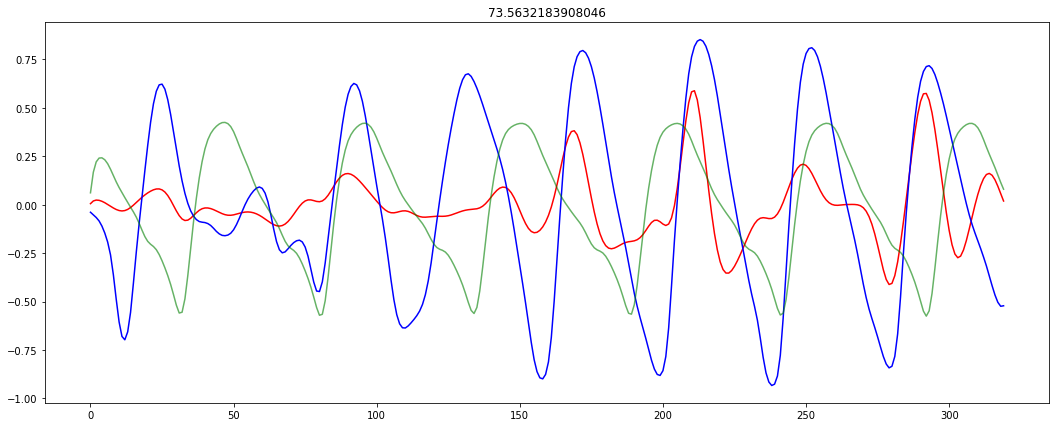

In [ ]:
a=next(iter(dataloader_v))
cos = nn.CosineSimilarity(dim=0, eps=1e-6)
x=a[0].float().to("cuda")
yhat=a[1].float().to("cuda")
net.eval()
y=net(x)
plt.figure(figsize=(18,7))
plt.plot(a[0][0][0],color='red')
#plt.plot(a[0][0][3])
plt.plot(y.view((-1,320))[0].cpu().detach().numpy(),color='blue')
plt.plot(a[1][0],color='green',alpha=0.6)
plt.title(a[2][0].cpu().detach().numpy()*250)
print(cos(y.view((-1,320))[0].cpu().detach(),a[1][0]).numpy())
test=cos(y.view((-1,320))[0].cpu().detach(),a[1][0])
cosine_loss=1-nn.CosineSimilarity(dim=1, eps=1e-6)(y.view((-1,320)), yhat)

In [ ]:
y.view((-1,320))[0].shape

torch.Size([320])

In [ ]:
torch.where(cosine_loss>0.3)

(tensor([ 1,  2,  4,  9, 10, 11, 12, 13, 16, 20, 26, 30, 31], device='cuda:0'),)

In [ ]:
x[torch.where(cosine_loss>0.3)].shape

torch.Size([13, 4, 320])

In [ ]:
cosine_loss>0.3

tensor([False,  True,  True, False,  True, False, False, False, False,  True,
         True,  True,  True,  True, False, False,  True, False, False, False,
         True, False, False, False, False, False,  True, False, False, False,
         True,  True], device='cuda:0')

0.0031374881941837207


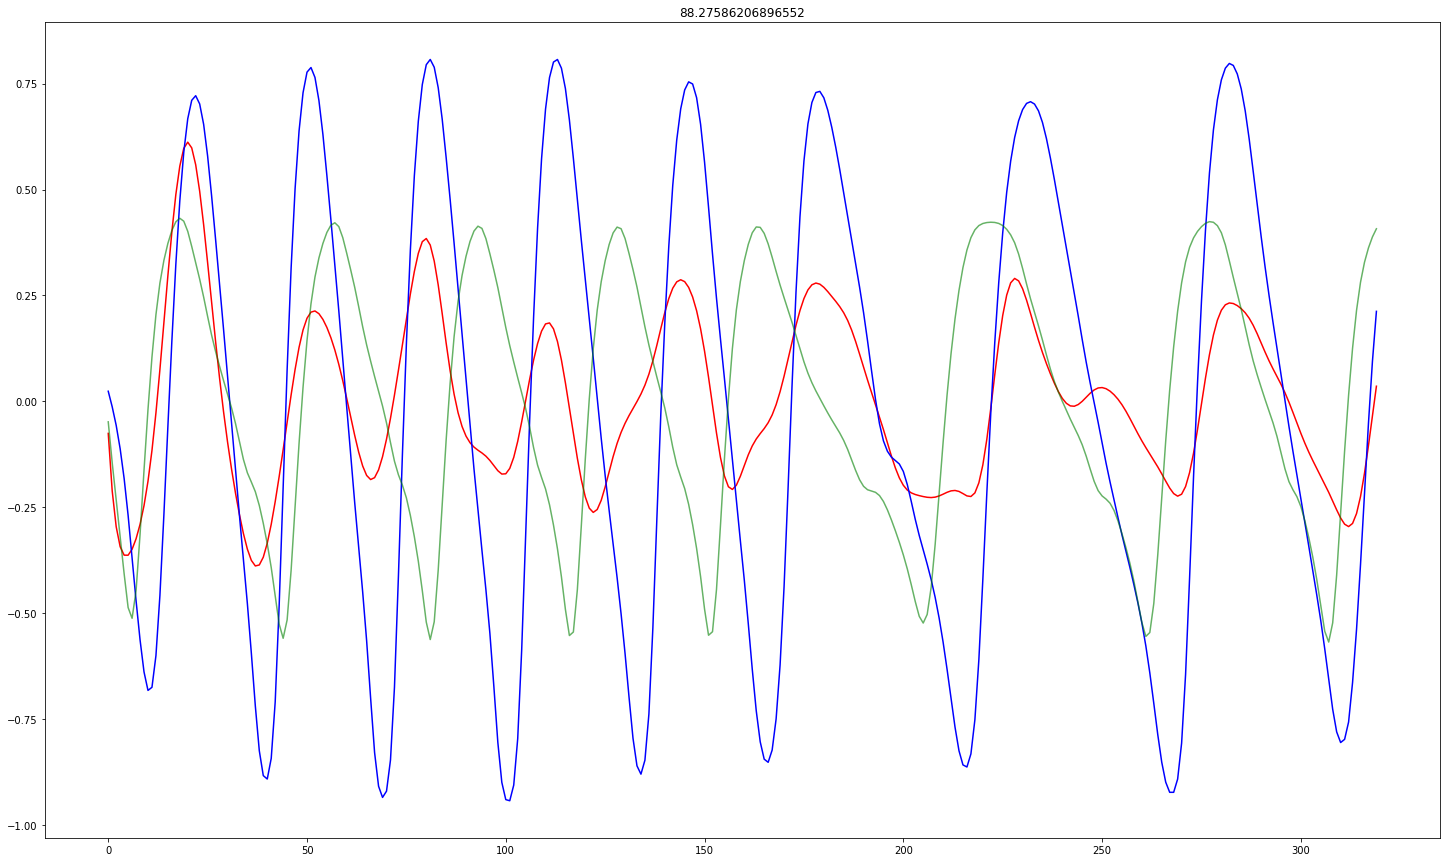

In [ ]:
a=next(iter(dataloader_t))
cos = nn.CosineSimilarity(dim=0, eps=1e-6)
x=a[0].float().to("cuda")
yhat=a[1].float().to("cuda")
net.eval()
y=net(x)
plt.figure(figsize=(25,15))
plt.plot(a[0][0][0],color='red')
#plt.plot(a[0][0][3])
plt.plot(y.view((-1,320))[0].cpu().detach().numpy(),color='blue')
plt.plot(a[1][0],color='green',alpha=0.6)
plt.title(a[2][0].cpu().detach().numpy()*250)
print(cos(y.view((-1,320))[0].cpu().detach(),a[1][0]).numpy())

In [ ]:
a[1][0].shape

torch.Size([320])

In [ ]:
ytest=y.view((-1,320))[31].cpu().detach().numpy()

In [ ]:
ytest=a[0][31][0].cpu().detach().numpy()

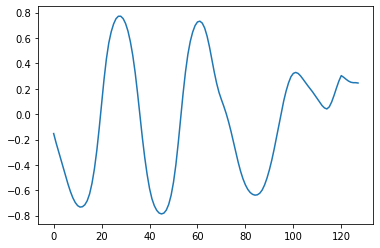

In [ ]:
plt.plot(ytest[320-128:320])

In [ ]:
ytest[320-128:320].shape

(128,)

In [ ]:
ar, P, k = aryule(ytest[320-128:320], order=30)
psd=arma2psd(ar,T=64,NFFT=5000)

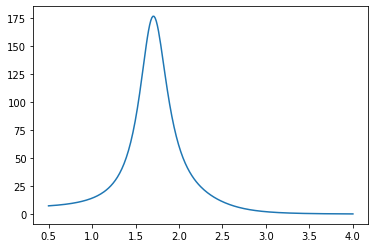

In [ ]:
plt.plot(np.linspace(0.5,4,314-39),psd[39:314])

In [ ]:
1+np.zeros((2,4))

array([[1., 1., 1., 1.],
       [1., 1., 1., 1.]])

In [ ]:
def ar_psd(signal,order,freq,NFFT):
    ar, P, k = aryule(signal, order)
    psd=arma2psd(ar,T=freq,NFFT=NFFT)
    return psd[39:314:1],psd[2*39:2*314:2]

def normalize(x):
  return (x-x.min())/(x.max()-x.min())

def compute_spectra(y,order):
  Lw=[]
  L2w=[]
  for n1 in range(y.shape[1]):
    sign=y[0][n1]
    psd_w,psd_2w=ar_psd(sign,order,64,5000)
    Lw.append(psd_w)
    L2w.append(psd_2w)
  spectr_w_bvp=normalize(np.array(Lw))
  spectr_2w_bvp=normalize(np.array(L2w))
  for n2 in range(1,y.shape[0]):
    Lw=[]
    L2w=[]
    for n1 in range(y.shape[1]):
      sign=y[0][n1]
      psd_w,psd_2w=ar_psd(sign,order,64,5000)
      Lw.append(psd_w)
      L2w.append(psd_2w)
    if n2==1:
      spectr_w_acc=normalize(np.array(Lw))
      spectr_2w_acc=normalize(np.array(L2w))
    else:
      spectr_w_acc=np.add(spectr_w_acc,normalize(np.array(Lw)))
      spectr_2w_acc=np.add(spectr_2w_acc,normalize(np.array(L2w)))
  spectr_w_acc=normalize(spectr_w_acc)
  spectr_w_acc=normalize(spectr_2w_acc)
  spectr_div_w=normalize(np.divide(0.5*spectr_w_bvp,spectr_w_acc+0.5))
  spectr_div_2w=normalize(np.divide(0.5*spectr_2w_bvp,spectr_2w_acc+0.5))
  return spectr_div_w,spectr_div_2w



x=a[0].float().to("cuda")
yhat=a[1].float().to("cuda")
zhat=a[2].float().to("cuda")
for k in range(1):
  xnoise=x#+np.sqrt(0.002)*torch.randn(x.shape).float().to("cuda")
  y=net(xnoise)
  ynoise=y#+np.sqrt(0.004)*torch.randn(y.shape).float().to("cuda")
  yconcat=torch.concat([ynoise,xnoise[:,1:,:]],dim=1)
  ypre_fft= yconcat.unfold(2,128,64).float().detach().cpu().numpy()
  sp_w,sp_2w=compute_spectra(ypre_fft[0],30)





In [ ]:
ypre_fft.shape

(32, 4, 4, 128)

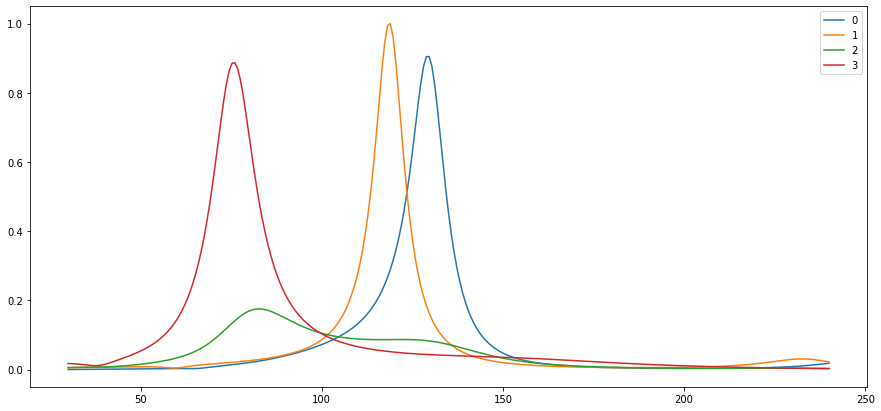

In [ ]:
plt.figure(figsize=(15,7))
for i in range(4):
  plt.plot(np.linspace(0.5,4,314-39)*60,sp_w[i],label=i)

plt.legend()

In [ ]:
np.argmax(sp_w[1])

26

In [ ]:
import scipy
scipy.fft.fftfreq(5000,1/64)[26+39]*60

49.92

In [ ]:
"""  
  for n0 in range(0,ypre_fft.shape[0]):
    spectra=[]
    for n1 in range(0,ypre_fft.shape[1]):
      L30_w,L100_w,L30_2w,L100_2w=[],[],[],[]
      if n1!=0:
        for n2 in range(0,ypre_fft.shape[2]):
          signal=ypre_fft[n0,n1,n2]
          psd30_w,psd30_2w=ar_psd(signal,30,64,5000)
          psd100_w,psd100_2w=ar_psd(signal,100,64,5000)
          L30_w.append(psd30_w)
          L30_2w.append(psd30_2w)
          L100_w.append(psd100_w)
          L100_2w.append(psd100_2w)
        spectr30_w=normalize(np.array(L30_w))
        spectr30_2w=normalize(np.array(L30_2w))
        spectr100_w=normalize(np.array(L100_w))
        spectr100_2w=normalize(np.array(L100_2w))
      #item=np.concatenate([item,spectr])"""

In [ ]:
yar=y.view((-1,320))[0].cpu().detach().numpy()

In [ ]:
ar, variance, coeff_reflection = spectrum.aryule(yar, 30)

In [ ]:
60*7/5

84.0

In [ ]:
yfft=torch.abs(torch.fft.fft(y.view((-1,320))[0],norm="ortho"))

In [ ]:
torch.fft.fftfreq(320,1/64)[4]

tensor(0.8000)

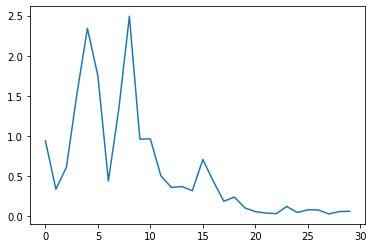

In [ ]:
plt.plot(yfft.cpu().detach().numpy()[0:30])

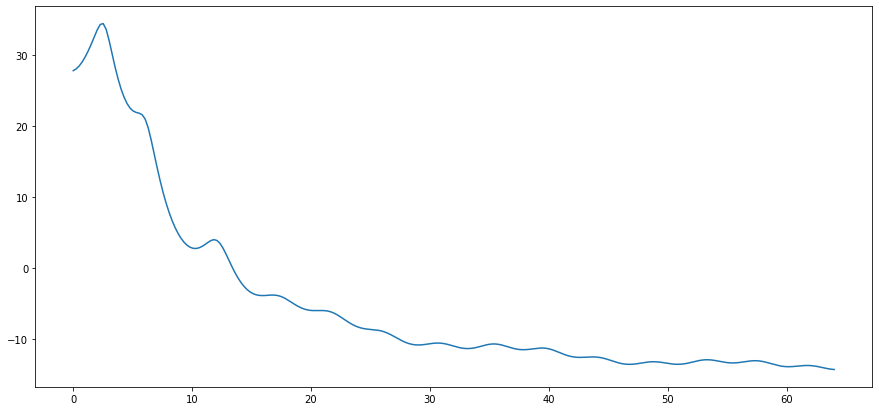

In [ ]:
PSD = spectrum.arma2psd(ar, NFFT=512)
PSD = PSD[len(PSD):int(len(PSD)/2):-1]
plt.figure(figsize=(15,7))
plt.plot(np.linspace(0, 1, len(PSD))*64,10*np.log10(abs(PSD)*2./(2.*np.pi)),
    label='Estimate of y using Yule-Walker AR(4)')

In [ ]:
net.load_state_dict(torch.load("./gdrive/MyDrive/Colab Notebooks/PPG Classifier/net_good_model.pth"))

<All keys matched successfully>

## Training Prediction

In [ ]:
def training_pred(net_clean,net_pred,dataloader_t,dataloader_v,num_epochs,fold):
  Loss = []
  Lossv= []
  cos = nn.CosineSimilarity(dim=1, eps=1e-6)
  net_clean.eval()
  for epoch in tqdm(range(num_epochs)):
      if epoch==0:
          lr=0.00005
          beta1=0.9
          optimizer = optim.Adam(net_pred.parameters(), lr=lr, betas=(beta1, 0.999),weight_decay=0.0005)
      L_t=[]
      L_v=[]
      net_pred.train()
      for i, dataj in enumerate(dataloader_t, 0):
          net_pred.zero_grad()
          zhat=dataj[4].float().to("cuda")
          yfft=dataj[3].float().to("cuda")
          yfft=yfft+np.sqrt(0.003)*torch.randn(yfft.shape).float().to("cuda")
          z=net_pred(yfft)
          err_t=nn.L1Loss()(z,zhat)
          err_t.backward()
          optimizer.step()
          L_t.append(err_t.item())
      for i, dataj in enumerate(dataloader_v, 0):
        net_pred.eval()     
        zhat=dataj[4].float().to("cuda")
        yfft=dataj[3].float().to("cuda")
        z=net_pred(yfft)
        err_v=nn.L1Loss()(z,zhat)
        L_v.append(err_v.item())
      err=np.mean(L_t)
      std=np.std(L_t)
      errv=np.mean(L_v)
      stdv=np.std(L_v)
      Loss.append([err,std])
      Lossv.append([errv,stdv])
      print("erreurt : {} et erreurv : {}".format(err*250,errv*250))
      #torch.save(net.state_dict(), "./gdrive/MyDrive/Colab Notebooks/PPG Classifier/net_good_model"+"_epoch_"+str(epoch)+".pth")

  return [Loss,Lossv]


In [ ]:
dataset_t_clean=ds_ppg_clean_t(net,dataloader_t)
dataset_v_clean=ds_ppg_clean_v(net,dataloader_v)
batch_size=32
num_workers=2
dataloader_t_clean = torch.utils.data.DataLoader(dataset_t_clean,batch_size=batch_size,shuffle=True,num_workers=num_workers,worker_init_fn=seed_worker,generator=g, drop_last=True)
dataloader_v_clean = torch.utils.data.DataLoader(dataset_v_clean,batch_size=batch_size,shuffle=True,num_workers=num_workers,worker_init_fn=seed_worker,generator=g, drop_last=True)

ValueError: ignored

In [ ]:
training_pred(net,net_pred,dataloader_t_clean,dataloader_v_clean,20,1)

  5%|▌         | 1/20 [02:22<45:10, 142.64s/it]

erreurt : 8.683449940395493 et erreurv : 9.007430871224809


 10%|█         | 2/20 [04:44<42:34, 141.92s/it]

erreurt : 8.619504351095395 et erreurv : 9.190515336335308


 15%|█▌        | 3/20 [07:04<40:03, 141.41s/it]

erreurt : 8.589006330351962 et erreurv : 8.401902994521743


 20%|██        | 4/20 [09:25<37:35, 140.98s/it]

erreurt : 8.51640663577893 et erreurv : 7.667807169673659


 25%|██▌       | 5/20 [11:45<35:13, 140.88s/it]

erreurt : 8.533067153393091 et erreurv : 7.749752009040496


 30%|███       | 6/20 [14:06<32:51, 140.79s/it]

erreurt : 8.508746444174815 et erreurv : 7.807173610546559


 35%|███▌      | 7/20 [16:27<30:29, 140.72s/it]

erreurt : 8.449822364312825 et erreurv : 8.092321207640524


 40%|████      | 8/20 [18:47<28:06, 140.51s/it]

erreurt : 8.480981467555472 et erreurv : 9.370252497761783


 45%|████▌     | 9/20 [21:07<25:44, 140.42s/it]

erreurt : 8.396217110456895 et erreurv : 7.876610254755666


 50%|█████     | 10/20 [23:33<23:42, 142.29s/it]

erreurt : 8.424901869305016 et erreurv : 7.943883306701868


 55%|█████▌    | 11/20 [25:58<21:26, 142.98s/it]

erreurt : 8.417042520287211 et erreurv : 8.27685437588841


 60%|██████    | 12/20 [28:21<19:04, 143.07s/it]

erreurt : 8.38995820348762 et erreurv : 7.798723978527288


 65%|██████▌   | 13/20 [30:44<16:40, 142.95s/it]

erreurt : 8.383634586398385 et erreurv : 7.580158269825231


 70%|███████   | 14/20 [33:07<14:17, 142.94s/it]

erreurt : 8.405969911352283 et erreurv : 9.839574622871908


 75%|███████▌  | 15/20 [35:30<11:55, 143.05s/it]

erreurt : 8.334574790841655 et erreurv : 7.658753909417608


 80%|████████  | 16/20 [37:53<09:32, 143.09s/it]

erreurt : 8.366223202047422 et erreurv : 8.396517457080316


 85%|████████▌ | 17/20 [40:19<07:11, 143.86s/it]

erreurt : 8.345854814121637 et erreurv : 8.007851834914906


 90%|█████████ | 18/20 [42:44<04:48, 144.31s/it]

erreurt : 8.31597619754371 et erreurv : 9.950716250008366


 95%|█████████▌| 19/20 [45:05<02:23, 143.35s/it]

erreurt : 8.286144529781428 et erreurv : 7.847434697881972


100%|██████████| 20/20 [47:25<00:00, 142.30s/it]

erreurt : 8.31003258392888 et erreurv : 7.862182559606724


[[[0.03473379976158197, 0.008458130362268392],
  [0.03447801740438158, 0.008398327120763419],
  [0.03435602532140785, 0.00841383784906028],
  [0.03406562654311572, 0.008249498364059495],
  [0.03413226861357237, 0.008293620751845547],
  [0.03403498577669926, 0.008217438739493708],
  [0.033799289457251296, 0.008342599314634172],
  [0.03392392587022189, 0.008345753016876473],
  [0.03358486844182758, 0.008349120562212705],
  [0.03369960747722006, 0.008255429309721606],
  [0.03366817008114884, 0.008364986166864518],
  [0.03355983281395048, 0.00813955953705755],
  [0.03353453834559354, 0.008021174323553511],
  [0.03362387964540913, 0.00836566970250681],
  [0.03333829916336662, 0.008079937036579405],
  [0.033464892808189685, 0.008254742342337858],
  [0.033383419256486545, 0.008430451645489508],
  [0.03326390479017484, 0.00800920449928276],
  [0.03314457811912571, 0.008306567151303415],
  [0.03324013033571552, 0.00830671688406387]],
 [[0.03602972348489924, 0.006972036367938615],
  [0.036762061

In [ ]:
import spectrum

In [ ]:
0.008021174323553511*250

2.005293580888378

In [ ]:
a=next(iter(dataloader_t_clean))

In [ ]:
a[3].shape

torch.Size([32, 4, 10, 314])

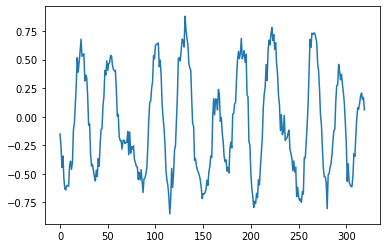

In [ ]:
plt.plot(a[2][0].view(-1))

In [ ]:
x[:,1:,:].shape

torch.Size([32, 3, 320])

In [ ]:
yconcat=torch.concat([y,x[:,1:,:]],dim=1)

In [ ]:
yconcat.shape

torch.Size([32, 4, 320])

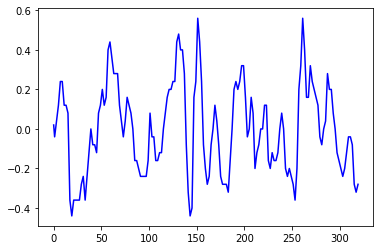

In [ ]:
plt.plot(yconcat[0][1].cpu().detach().numpy(),color='blue')

In [ ]:
ypre_fft= yconcat.unfold(2,124,20)

In [ ]:
ypre_fft.shape

torch.Size([32, 4, 10, 124])

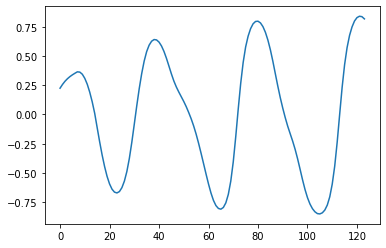

In [ ]:
plt.plot(ypre_fft[0][0][0].cpu().detach().numpy())

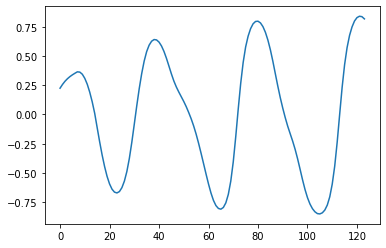

In [ ]:
plt.plot(ypre_fft[0][0][0].cpu().detach().numpy())

In [ ]:
torch.fft.fftfreq(5000,1/64)[0:314]

In [ ]:
torch.fft.fftfreq(5000,1/64)[2]*60-torch.fft.fftfreq(5000,1/64)[1]*60

tensor(0.7680)

In [ ]:
yfft=torch.abs(torch.fft.fft(ypre_fft,dim=3,n=5000,norm="ortho"))[:,:,:,:314]

In [ ]:
yfft.shape

torch.Size([32, 4, 10, 314])

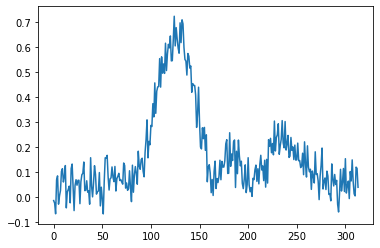

In [ ]:
plt.plot((yfft+np.sqrt(0.003)*torch.randn(yfft.shape).float().to("cuda"))[0][0][0].cpu().detach().numpy())

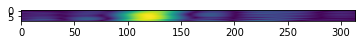

In [ ]:
plt.imshow(yfft[0][0].cpu().detach().numpy())

In [ ]:
a=next(iter(dataloader_t))

In [ ]:
x=a[0].float().to("cuda")
yhat=a[1][1].float().to("cuda")

In [ ]:
plt.plot(yhat.cpu())

In [ ]:
net.eval()
y=net(x)

In [ ]:
plt.plot(y[1].cpu().detach().numpy())

In [ ]:
!rm -r net
!mkdir net
manualSeed=1
g = torch.Generator()
g.manual_seed(manualSeed)
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)
L=[]
i=0
for ds in Datasets_kfold:
  net= Model("ngpu").to("cuda")
  net.apply(init_weight)
  batch_size=64
  num_workers=2 
  dataset_t=ds[0]
  dataset_v=ds[1]
  dataloader_t = torch.utils.data.DataLoader(dataset_t,batch_size=batch_size,shuffle=True,num_workers=num_workers,worker_init_fn=seed_worker,generator=g, drop_last=True)
  dataloader_v = torch.utils.data.DataLoader(dataset_v,batch_size=batch_size,shuffle=True,num_workers=num_workers,worker_init_fn=seed_worker,generator=g, drop_last=True)
  L.append(training(net,dataloader_t,dataloader_v,50,i))
  i+=1
  print(i)

100%|██████████| 50/50 [05:35<00:00,  6.72s/it]


1


100%|██████████| 50/50 [05:29<00:00,  6.58s/it]


2


100%|██████████| 50/50 [05:34<00:00,  6.69s/it]


3


100%|██████████| 50/50 [05:30<00:00,  6.60s/it]


4


100%|██████████| 50/50 [05:36<00:00,  6.73s/it]


5


100%|██████████| 50/50 [05:33<00:00,  6.67s/it]


6


100%|██████████| 50/50 [05:34<00:00,  6.69s/it]


7


100%|██████████| 50/50 [05:37<00:00,  6.74s/it]


8


100%|██████████| 50/50 [05:32<00:00,  6.66s/it]


9


100%|██████████| 50/50 [05:40<00:00,  6.80s/it]

10
